# Softmax Regression - Classification of the wines to classes of quality

Label vector is hot-encoded. This means if a wine has been classified to the class no. 6 hot-encoded label looks like this: (0, 0, 0, 0, 0, 1) because only six different classes has been found in the training data (6 different classes on the scale 1-10). Output from a softmax regression for each row of the training dataset is a maximum probability from a vector of probabilities, where each probability is computed as a:

ration between exponentiated logits (outputs from linear functions of the neurons) / and sum of the exponentiated logits.
See https://d2l.ai/chapter_linear-networks/softmax-regression.html#softmax-operation for futher description.

Loss function for this example is a Cross-Entropy Loss and formula for this can be found in https://d2l.ai/chapter_linear-networks/softmax-regression.html#softmax-and-derivatives . Formal definition of a Cross-entropy loss is that it is the expected value of the loss for a distribution over labels.

Metric we use to evaluate our model is accuracy, which is a ratio between the number of correct predictions and the total number of predictions.

No need to convert attribute with maximum difference between lowest and highest value because this conversion is usually done for highly-skewed data. 

Train labels are hot-encoded as well. 

Batch size set to 10, dataset is shuffled before predictions are made. Remember that model cannot work with labels while training.

Softmax is described here: https://d2l.ai/chapter_linear-networks/softmax-regression.html

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
!wandb login 8b57643f3a4972621becd97c751a7c84995678d4 
from wandb.keras import WandbCallback

tf.keras.backend.clear_session()

wandb.init(name='softmax-regression-tensorflow', 
           project='project-nn', 
           tags=['RED_WINE dataset', '1. run'])

red_wine = pd.read_csv('winequality-red.csv', sep = ';')
train, val, test = np.split(red_wine.sample(frac=1, random_state=42), [int(.6*len(red_wine)), int(.8*len(red_wine))])

train.to_csv('winequality-red-train.csv', index=False)
test.to_csv('winequality-red-test.csv', index=False)
val.to_csv('winequality-red-val.csv', index=False)

train_df = pd.read_csv('winequality-red-train.csv', sep = ',')
val_df = pd.read_csv('winequality-red-val.csv', sep = ',')
test_df = pd.read_csv('winequality-red-test.csv', sep = ',')

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\vikto/.netrc
wandb: Currently logged in as: nn_fiit (use `wandb login --relogin` to force relogin)


Normalizing dataset

In [2]:
scaler = StandardScaler()
train_features = scaler.fit(train.drop(['quality'], axis=1).values)

X_train = pd.DataFrame(scaler.transform(train.iloc[:, 0:-1].values))
y_train = to_categorical(train.iloc[:,-1].values, 10)

X_val = pd.DataFrame(scaler.transform(val.iloc[:, 0:-1].values))
y_val = to_categorical(val.iloc[:,-1].values, 10)

X_test = pd.DataFrame(scaler.transform(test.iloc[:, 0:-1].values))
y_test = to_categorical(test.iloc[:,-1].values, 10)

Visualization of class imbalance

Text(0.5, 0.98, 'Distribution of residual sugar and sulphates')

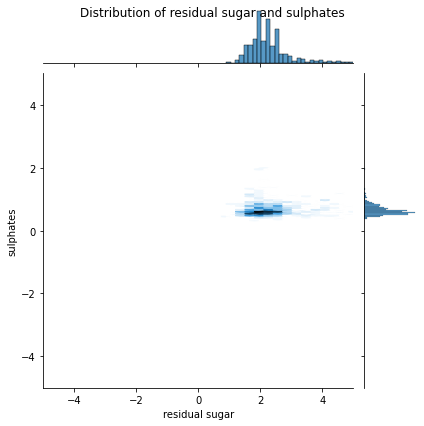

In [3]:
# we're dealing with imbalanced dataset
# number of examples in one class greatly outnumbers the examples in another
# most present classes are 6, 7 and 8
class_counts = np.bincount(red_wine['quality'])

# visualize distribution of residual sugar and sulphates
# you can pass any two columns to compare their values
# remember to filter and use only those rows from training dataset which have labels (wine quality) assigned

rows_with_labels = pd.DataFrame(np.array(train_df), columns=train_df.columns)

sns.jointplot(x=rows_with_labels['residual sugar'], y=rows_with_labels['sulphates'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Distribution of residual sugar and sulphates")

Weighting imbalanced classes

We don't want to heavily depend to the most present classes in our dataset. There are 422 red wines classified into the 5th quality class but only four of them are in a fourth. We will pass these class weights to the Keras while fitting the model (see below).

Weight for a class is  (1/(number of samples with this class))*((sum of the class frequencies)*10) and same approach can be find here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
sum_class = sum(train['quality'].value_counts().sort_index())
weights = [sum_class/10, sum_class/10]
for class_count in train['quality'].value_counts().sort_index():
    weights.append((1/class_count) * (sum_class/10))
weights.append(sum_class/10)
weights.append(sum_class/10)

class_weights = {
    0: weights[0],
    1: weights[1],
    2: weights[2],
    3: weights[3],
    4: weights[4],
    5: weights[5],
    6: weights[6],
    7: weights[7],
    8: weights[8],
    9: weights[9],
}

Setting up model and predicting

In [5]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(11, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax")
])


model.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=["accuracy"])

BATCH_SIZE = 32
EPOCHS = 100
SHUFFLE = True

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), shuffle=SHUFFLE, class_weight=class_weights, callbacks=[WandbCallback()])

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 6.2154 - accuracy: 0.0083 - val_loss: 2.4707 - val_accuracy: 0.0250 - _timestamp: 1647888217.0000 - _runtime: 6.0000
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 5.8576 - accuracy: 0.0678 - val_loss: 2.4137 - val_accuracy: 0.0906 - _timestamp: 1647888217.0000 - _runtime: 6.0000
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 5.4977 - accuracy: 0.1074 - val_loss: 2.4074 - val_accuracy: 0.1156 - _timestamp: 1647888217.0000 - _runtime: 6.0000
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 5.0120 - accuracy: 0.1189 - val_loss: 2.4499 - val_accuracy: 0.1281 - _timestamp: 1647888217.0000 - _runtime: 6.0000
Epoch 5/100
30/30 [==============================] - 0s 1ms/step - loss: 4.4802 - accuracy: 0.1241 - val_loss: 2.5065 - val_accuracy: 0.1312 - _timestamp: 1647888217.0000 - _runtime: 6.0000
Epoch 6/100
30/30 [==============================]

Epoch 44/100
30/30 [==============================] - 0s 1ms/step - loss: 1.6044 - accuracy: 0.3806 - val_loss: 1.6216 - val_accuracy: 0.3344 - _timestamp: 1647888219.0000 - _runtime: 8.0000
Epoch 45/100
30/30 [==============================] - 0s 2ms/step - loss: 1.5618 - accuracy: 0.3952 - val_loss: 1.5632 - val_accuracy: 0.3531 - _timestamp: 1647888219.0000 - _runtime: 8.0000
Epoch 46/100
30/30 [==============================] - 0s 1ms/step - loss: 1.5620 - accuracy: 0.3952 - val_loss: 1.6086 - val_accuracy: 0.3438 - _timestamp: 1647888219.0000 - _runtime: 8.0000
Epoch 47/100
30/30 [==============================] - 0s 1ms/step - loss: 1.5458 - accuracy: 0.3962 - val_loss: 1.5615 - val_accuracy: 0.3500 - _timestamp: 1647888219.0000 - _runtime: 8.0000
Epoch 48/100
30/30 [==============================] - 0s 1ms/step - loss: 1.5407 - accuracy: 0.3931 - val_loss: 1.5639 - val_accuracy: 0.3625 - _timestamp: 1647888219.0000 - _runtime: 8.0000
Epoch 49/100
30/30 [=========================

Epoch 87/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1232 - accuracy: 0.4202 - val_loss: 1.5346 - val_accuracy: 0.3781 - _timestamp: 1647888221.0000 - _runtime: 10.0000
Epoch 88/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1046 - accuracy: 0.4140 - val_loss: 1.5188 - val_accuracy: 0.3906 - _timestamp: 1647888221.0000 - _runtime: 10.0000
Epoch 89/100
30/30 [==============================] - 0s 1ms/step - loss: 1.0997 - accuracy: 0.4254 - val_loss: 1.5706 - val_accuracy: 0.3688 - _timestamp: 1647888221.0000 - _runtime: 10.0000
Epoch 90/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1167 - accuracy: 0.4171 - val_loss: 1.5720 - val_accuracy: 0.3656 - _timestamp: 1647888221.0000 - _runtime: 10.0000
Epoch 91/100
30/30 [==============================] - 0s 1ms/step - loss: 1.0988 - accuracy: 0.4140 - val_loss: 1.5530 - val_accuracy: 0.3812 - _timestamp: 1647888221.0000 - _runtime: 10.0000
Epoch 92/100
30/30 [====================

Now we have to evaluate our classification model. Non-overfitting softmax regression model for us is a model with roughly same accuracy on the training, validation and test dataset. Visualization through the confusion matrix will help us evaluate model performance on these three types of the data sets. 

So now we're going to check our classification accuracy on the training dataset.

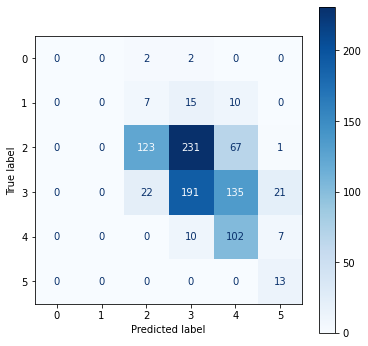

In [6]:
from sklearn import metrics

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(6))
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    
train_set_probabilities_for_classes = model.predict(X_train)
# class with a maximum probability is our predicted quality class
train_set_predicted_classes = np.argmax(train_set_probabilities_for_classes, axis = 1)
y_train_class = np.argmax(y_train, axis = 1)
confusion_matrix(y_train_class, train_set_predicted_classes)

plot_confusion_matrix(y_train_class, train_set_predicted_classes)

Second step is where we have to check our classification capacity on the validation set.

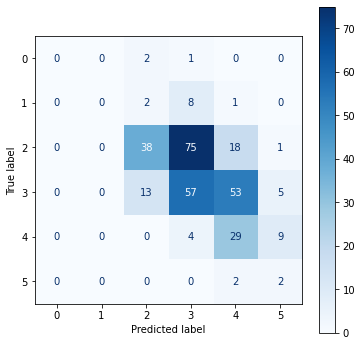

In [7]:
validation_set_probabilities_for_classes = model.predict(X_val)
# class with a maximum probability is our predicted quality class
validation_set_predicted_classes = np.argmax(validation_set_probabilities_for_classes, axis = 1) 
y_val_class = np.argmax(y_val, axis = 1)
confusion_matrix(y_val_class, validation_set_predicted_classes)

plot_confusion_matrix(y_val_class, validation_set_predicted_classes)

Third step is when we have to check model performance on the test set.

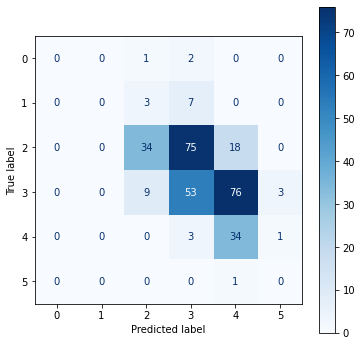

In [8]:
test_set_probabilities_for_classes = model.predict(X_test)
# class with a maximum probability is our predicted quality class
test_set_predicted_classes = np.argmax(test_set_probabilities_for_classes, axis = 1) 
y_test_class = np.argmax(y_test, axis = 1)
confusion_matrix(y_test_class, test_set_predicted_classes)

plot_confusion_matrix(y_test_class, test_set_predicted_classes)

# Conclusion

Our classification model behaves roughly the same on the training, validation and test dataset.